In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../../")

In [28]:
from config.config import BASE_PATH, PATH_TO_PATH_CONFIG_FILE
from src.utils import load_paths_from_yaml, replace_base_path
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import seaborn as sns
import matplotlib.pyplot as plt

from src.modeling.encodings import (convert_aspect_to_cardinal_direction, 
                                    convert_canopy_cover_to_classes, 
                                    convert_ffmc_to_classes)

In [4]:
paths = load_paths_from_yaml(PATH_TO_PATH_CONFIG_FILE)
paths = replace_base_path(paths, BASE_PATH)

In [5]:
def add_static_feature_from_raster(events: gpd.GeoDataFrame,
                                   path_to_raster: str, feature_name: str) -> gpd.GeoDataFrame:

    with rasterio.open(path_to_raster) as src:
        coords = list(zip(events.geometry.x, events.geometry.y))
        events_updated = events.copy()
        events_updated[feature_name] = [x[0] for x in src.sample(coords)]

        events_updated.loc[events_updated[feature_name] ==
                           src.profile["nodata"], feature_name] = np.nan

    return gpd.GeoDataFrame(
        events_updated, geometry="geometry", crs="EPSG:31287")  # type: ignore

In [6]:
# define paths
path_to_fire_events_eval = paths["ffmc_adjustment_eval_events"]["source"]
path_to_fire_events_ffmc = paths["ffmc_events"]["source"]
path_to_forest_type = paths["forest_type"]["final"]
path_to_canopy_cover = paths["canopy_cover"]["final"]
path_to_aspect = paths["topographical_layers"]["aspect"]["final"]

In [7]:
# read in selected fire events for evaluation provided by BOKU Mortimer Müller
fire_events_eval = pd.read_csv(path_to_fire_events_eval, encoding="latin1")
fire_events_eval = gpd.GeoDataFrame(
    fire_events_eval, 
    geometry=gpd.points_from_xy(fire_events_eval.WGS84_long_dez, fire_events_eval.WGS84_lat_dez), 
    crs="EPSG:4326"
)
fire_events_eval.to_crs(epsg="31287", inplace=True)

In [8]:
# read in ffmc values for all fire events provided by BOKU Christian Schmidt
fire_events_ffmc = pd.read_csv(path_to_fire_events_ffmc)
fire_events_ffmc = gpd.GeoDataFrame(
    fire_events_ffmc, 
    geometry=gpd.points_from_xy(fire_events_ffmc.x, fire_events_ffmc.y), 
    crs="EPSG:31287"
)
fire_events_ffmc = fire_events_ffmc[fire_events_ffmc.fire == 1]

In [9]:
# match on Datum and distance between ignition locations (< 10)
fire_events_eval_ffmc = fire_events_eval.merge(fire_events_ffmc, left_on="Datum", right_on="date", how="inner")

def calculate_distance(row):
    return row['geometry_x'].distance(row['geometry_y'])

fire_events_eval_ffmc['distance'] = fire_events_eval_ffmc.apply(calculate_distance, axis=1)
fire_events_eval_ffmc = fire_events_eval_ffmc[fire_events_eval_ffmc.distance < 10]

fire_events_eval_ffmc = gpd.GeoDataFrame(
    fire_events_eval_ffmc, 
    geometry="geometry_x", 
    crs="EPSG:31287"
)

fire_events_eval_ffmc.rename_geometry("geometry", inplace=True)


In [10]:
# get additional features
fire_events_eval = add_static_feature_from_raster(fire_events_eval_ffmc, path_to_forest_type, "foresttype")
fire_events_eval = add_static_feature_from_raster(fire_events_eval, path_to_canopy_cover, "canopy_cover")
fire_events_eval = add_static_feature_from_raster(fire_events_eval, path_to_aspect, "aspect")

In [11]:
# categorize features according to ffmc adjustment of BOKU
fire_events_eval["aspect_categorized"] = fire_events_eval.aspect.apply(convert_aspect_to_cardinal_direction)
fire_events_eval["canopy_cover_categorized"] = fire_events_eval.canopy_cover.apply(convert_canopy_cover_to_classes)
fire_events_eval["ffmc_categorized"] = fire_events_eval.ffmc.apply(convert_ffmc_to_classes)
fire_events_eval_cleaned = fire_events_eval.dropna(subset=("foresttype", "canopy_cover"))
fire_events_eval_cleaned.loc[:,"foresttype"] = fire_events_eval_cleaned["foresttype"].astype("int")

# slim down df to relevant columns
relevant_columns = ['WaldbrandID', 'Datum', 'foresttype', "aspect_categorized", "canopy_cover_categorized", "ffmc_categorized", "ffmc"]
fire_events_eval_cleaned = fire_events_eval_cleaned[relevant_columns]

C:\Users\b1105474\AppData\Local\Temp\ipykernel_12164\1147066027.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_events_eval_cleaned.loc[:,"foresttype"] = fire_events_eval_cleaned["foresttype"].astype("int")
C:\Users\b1105474\AppData\Local\Temp\ipykernel_12164\1147066027.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  fire_events_eval_cleaned.loc[:,"foresttype"] = fire_events_eval_cleaned["foresttype"].astype("int")


In [12]:
# calculate ffmc adjustment for each event 
adj_matrix_cc = np.array([[3, 3, 2, 1, 0], # <20%
                        [2, 2, 1, 0, 0], # 20-40
                        [0, 0, 0, 0, 0], # 40-60
                        [-2, -2, -1, 0, 0], # 60-80
                        [-3, -3, -2, -1, 0]]) # >80

adj_matrix_ft = np.array([[0, 0, 0, 0, 0], # coniferous non pine (Fichte, Tanne, Lärche)
                        [-4, -3, -2, -1, 0], # coniferous with mixed pine (Misch-Hochwald)
                        [4, 3, 2, 1, 0], # pine pure (Kiefer)
                        [-4, -3, -2, -1, 0], # coniferous deciduous mixed with pine (Misch Hochwald)
                        [-4, -3, -2, -1, 0], # coniferous_deciduous mixed_non_pine (Misch-Hochwald)
                        [-5, -4, -3, -2, -1], #deciduous pure (Laubwald)
                        [-5, -4, -3, -2, -1]]) # low and no vegetation (Niederwald)

adj_matrix_asp = np.array([[-8, -7, -3, -2, -1], # N
                        [-7, -3, -2, -1, 0], # NE
                        [0, 0, 0, 0, 0], # E
                        [7, 3, 2, 1, 0], # SE
                        [8, 7, 3, 2, 1], # S
                        [7, 3, 2, 1, 0], # SW
                        [0, 0, 0, 0, 0], # W
                        [-7, -3, -2, -1, 0]]) # NW

def adjust_ffmc_with_matrix(row, adj_matrix, adj_var, ffmc_var):
    adj_value = adj_matrix[row[adj_var], row["ffmc_categorized"]]
    return row[ffmc_var] + adj_value

# adjust ffmc with expert-based approach (eb)
fire_events_eval_cleaned["ffmc_adjusted_eb"] = fire_events_eval_cleaned.apply(lambda row: 
                                                                           adjust_ffmc_with_matrix(row, adj_matrix_ft, "foresttype", "ffmc"), axis=1)
fire_events_eval_cleaned["ffmc_adjusted_eb"] = fire_events_eval_cleaned.apply(lambda row: 
                                                                           adjust_ffmc_with_matrix(row, adj_matrix_cc, "canopy_cover_categorized", "ffmc_adjusted_eb"), axis=1)
fire_events_eval_cleaned["ffmc_adjusted_eb"] = fire_events_eval_cleaned.apply(lambda row: 
                                                                           adjust_ffmc_with_matrix(row, adj_matrix_asp, "aspect_categorized", "ffmc_adjusted_eb"), axis=1)

fire_events_eval_cleaned["ffmc_diff_eb"] = fire_events_eval_cleaned["ffmc_adjusted_eb"] - fire_events_eval_cleaned["ffmc"]

### Calculate updated adjustment matrices

In [35]:
# weights derived from model using all data
aspect_weights = np.array([1.09, 0.84, 0.55, 1, 1.35, 1.07, 1.03, 1.14])
canopy_cover_weights = np.array([1.5, 1.33, 1.03, 1.04, 0.8])
foresttype_weights = np.array([1.42, 1.00, 1.17, 0.79, 0.91, 0.86, 1.39])

# weights derived from model using only fire events with location uncertainty < 250
aspect_weights = np.array([0.48, 0.77, 0.53, 1.10, 1.41, 1.24, 1.45, 1.13])
canopy_cover_weights = np.array([1.5, 1.95, 1.10, 1.55, 0.96])
foresttype_weights = np.array([1.01, 1.01, 1.17, 0.95, 1, 0.94, 1.06])

# use the the maximum positive adjustment values given by experts as anchor for calculation of new adjustment values
aspect_max_anchor = adj_matrix_asp[4]
canopy_cover_max_anchor = adj_matrix_cc[0]
foresttype_max_anchor = adj_matrix_ft[2]

aspect_weights_adjusted = np.round((aspect_weights - 1) / np.max(aspect_weights - 1), 2)
adj_matrix_asp_db = np.outer(aspect_weights_adjusted, aspect_max_anchor)

canopy_cover_weights_adjusted = np.round((canopy_cover_weights - 1) / np.max(canopy_cover_weights - 1), 2)
adj_matrix_cc_db = np.outer(canopy_cover_weights_adjusted, canopy_cover_max_anchor)

foresttype_weights_adjusted = np.round((foresttype_weights - 1) / np.max(foresttype_weights - 1), 2)
adj_matrix_ft_db = np.outer(foresttype_weights_adjusted, foresttype_max_anchor)

In [31]:
# adjust ffmc with data-based approach (db)
fire_events_eval_cleaned["ffmc_adjusted_db"] = fire_events_eval_cleaned.apply(lambda row: 
                                                                           adjust_ffmc_with_matrix(row, adj_matrix_ft_db, "foresttype", "ffmc"), axis=1)
fire_events_eval_cleaned["ffmc_adjusted_db"] = fire_events_eval_cleaned.apply(lambda row: 
                                                                           adjust_ffmc_with_matrix(row, adj_matrix_cc_db, "canopy_cover_categorized", "ffmc_adjusted_db"), axis=1)
fire_events_eval_cleaned["ffmc_adjusted_db"] = fire_events_eval_cleaned.apply(lambda row: 
                                                                           adjust_ffmc_with_matrix(row, adj_matrix_asp_db, "aspect_categorized", "ffmc_adjusted_db"), axis=1)

fire_events_eval_cleaned["ffmc_diff_db"] = fire_events_eval_cleaned["ffmc_adjusted_db"] - fire_events_eval_cleaned["ffmc"]

-21.0
42.43999999999997


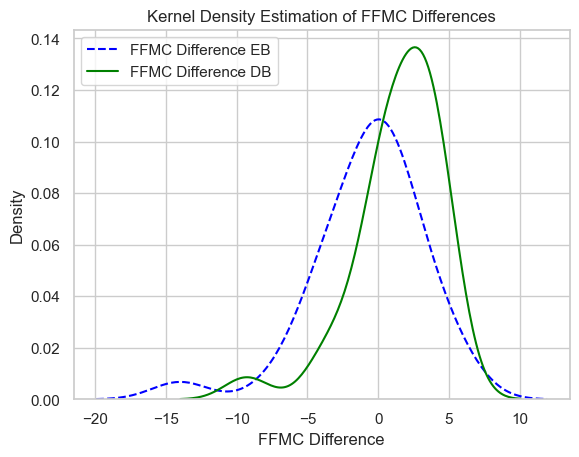

In [36]:
print(fire_events_eval_cleaned["ffmc_diff_eb"].sum())
print(fire_events_eval_cleaned["ffmc_diff_db"].sum())

# Assuming fire_events_eval_cleaned.ffmc_diff_eb and fire_events_eval_cleaned.ffmc_diff_db are your data
sns.set_theme(style="whitegrid")  # Setting style

# Plotting KDE plots
sns.kdeplot(fire_events_eval_cleaned.ffmc_diff_eb, label='FFMC Difference EB', color='blue', linestyle='--')
sns.kdeplot(fire_events_eval_cleaned.ffmc_diff_db, label='FFMC Difference DB', color='green', linestyle='-')

# Adding labels and title
plt.xlabel('FFMC Difference')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of FFMC Differences')
plt.legend()

# Showing plot
plt.show()